<h3>Bin covering problem</h3>
The goal is to fill multiple bins with items of the highest value so as not to exceed the size of the bin.

In [127]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt

Setting parameters

In [128]:
Items_size = {}
Items_value = {}
bins = [100,50,40,120]
n = 100
for i in range(n):
    item = f'P{i}'
    Items_size[item] = np.random.randint(30,100)
    Items_value[item] = np.random.randint(2,20)
print(f'Summed size: {np.sum(list(Items_size.values()))}')
print(f'Summed value: {np.sum(list(Items_value.values()))}')

Summed size: 6660
Summed value: 1134


In [129]:
m = Model('BCP')

Adding a decision variable and defining temporary parameters (for better visibility)

In [130]:
x = m.addMVar((len(bins),len(Items_size.keys())), vtype=GRB.BINARY,name='items')
y_values = np.array(list(Items_value.values()))
y_size = np.array(list(Items_size.values()))

Setting objective.<br>
The objective is maximising value of items used.

In [131]:
m.setObjective(sum(x[i,:]@y_values for i in range(len(bins))),GRB.MAXIMIZE)

Setting constraints. <br>
First constraints limits use of items due to the volume of bin. <br>
Second one forbids to use one item more then once.

In [132]:
%%capture
m.addConstrs((x[i,:]@y_size) <= np.array(bins[i]) for i in range(len(bins)))
m.addConstrs((sum(x[:,i]) <= 1 for i in range(n)))

In [133]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 104 rows, 400 columns and 800 nonzeros
Model fingerprint: 0x958ff9dc
Variable types: 0 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 56.0000000
Presolve removed 0 rows and 167 columns
Presolve time: 0.00s
Presolved: 104 rows, 233 columns, 466 nonzeros
Variable types: 0 continuous, 233 integer (233 binary)
Found heuristic solution: objective 94.0000000

Root relaxation: objective 1.371364e+02, 13 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  137.13636    0    5   94.00000  137.13636  45.9%    

In [134]:
x.X

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,
         0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

Printing solution

In [135]:
sum_value = 0
sum_size = 0
sum_ans = []
for i in range(len(bins)):
    temp_size = 0
    temp_value = 0
    ans = []
    for j in range(n):
        if x[i,j].X > 0:
            ans.append(list(Items_size.keys())[j])
    for l in ans:
        temp_size += Items_size[l]
        temp_value += Items_value[l]
    sum_size += temp_size
    sum_value += temp_value
    sum_ans += ans
    print(f'Bin {i} - Value: {temp_value} - Size: {temp_size}/{bins[i]}')
    print(ans)
                
print('---SUMMARY---')
print(f'Summed value : {sum_value}\nSummed size: {sum_size}')
print(f'Used items:\n{sorted(sum_ans)}')

Bin 0 - Value: 48 - Size: 100/100
['P55', 'P71', 'P73']
Bin 1 - Value: 19 - Size: 44/50
['P23']
Bin 2 - Value: 18 - Size: 37/40
['P24']
Bin 3 - Value: 50 - Size: 120/120
['P68', 'P84', 'P90']
---SUMMARY---
Summed value : 135
Summed size: 301
Used items:
['P23', 'P24', 'P55', 'P68', 'P71', 'P73', 'P84', 'P90']


<h3>Tabu search</h3>

In [136]:
def chceck_constr(x):
    if multi_items_constr(x) == False:
        return False
    if sum_constr(x) == False:
        return False
    return True

Checking if we use one item multiple times.

In [137]:
def multi_items_constr(x):
    for i in range(len(y_size)):
        if sum(x[:,i]) > 1:
            print(f'One item is used multiple times.\n{x[:,i]} - column {i}')
            return False
    print('Passed test 1')
    return True

Checking if sum is larger than bin size.

In [138]:
def sum_constr(x):
    print('Test 2')
    for i in range(len(bins)):
        Sum = 0
        for j in range(len(y_size)):
            Sum += x[i,j]*y_size[j]
        print(f'Bin {i} - {Sum}/{bins[i]}')
        if Sum > bins[i]:
            print(f'Error')
            return False
    print('Passed test 2')
    return True

Summing value and size of current result

In [139]:
def Sum_value(x):
    Sum_values = 0
    Sum_size = 0
    for i in range(len(bins)):
        for j in range(len(y_values)):
            Sum_values += x[i,j]*y_values[j]
            Sum_size += x[i,j]*y_size[j]
    return Sum_values, Sum_size

Generating first random solution

In [140]:
%%capture
flag = False
while flag == False:
    x_rand = np.array([[0 for _ in range(len(y_size))] for _ in range(len(bins)) ])
    for _ in range(10):
        x_rand[np.random.randint(0,len(bins)),np.random.randint(0,len(y_size))] += np.random.randint(0,2)
    flag = chceck_constr(x_rand)
value_rand, size_rand= Sum_value(x_rand)
print(flag,value_rand,x_rand)

Searching
1. Generate random point
2. If this point is in use than switch it to 0. If not - switch to 1
3. Check constrains
4. If test are passed append array to dict and return new solution. Else, return original solution

In [141]:
def tabu_search(x,i):
    global Tabu
    global tabu_plot_value
    global tabu_plot_size
    x_new = x.copy()
    point = [np.random.randint(0,len(bins)),np.random.randint(0,len(y_size))]
    if x_new[point[0],point[1]] == 1:
        x_new[point[0],point[1]] = 0
    else:
        x_new[point[0],point[1]] = 1
    if chceck_constr(x_new) == False:
        value,size = Sum_value(x)
        tabu_plot_value[i] = value
        tabu_plot_size[i] = size
        return x
    else:
        value,size = Sum_value(x_new)
        tabu_plot_value[i] = value
        tabu_plot_size[i] = size
        Tabu[value] = x_new
        return x_new

In [142]:
%%capture
Tabu = {}
iterations = 10000
tabu_plot_value = [0 for _ in range(iterations)]
tabu_plot_size = [0 for _ in range(iterations)]
x = x_rand.copy()
for i in range(iterations):
    x = tabu_search(x,i)
value_max,size_max = Sum_value(Tabu[max(list(Tabu.keys()))])

In [143]:
print(f'Sum 0 - {value_rand} | Size 0 - {size_rand}\nSum N - {value_max} | Size N - {size_max}\n{Tabu[max(list(Tabu.keys()))]}')
chceck_constr(Tabu[max(list(Tabu.keys()))])

Sum 0 - 12 | Size 0 - 52
Sum N - 103 | Size N - 283
[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]
Passed test 1
Test 2
Bin 0 - 94/100
Bin 1 - 34/50
Bin 2 - 38/40
Bin 3 - 117/120
Passed test 2


True

<h3>Making plots</h3>

In [144]:
for i in range(len(tabu_plot_value)):
    if tabu_plot_value[i] == value_max and tabu_plot_size[i] == size_max:
        point = i

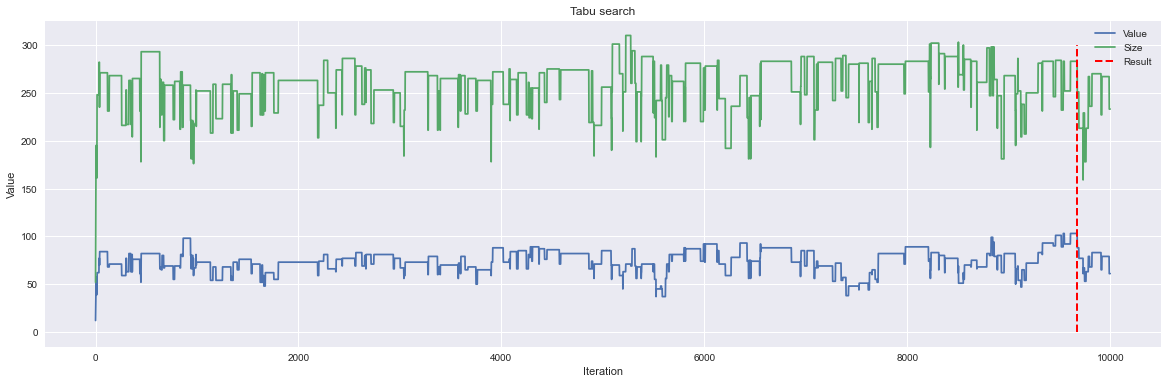

In [145]:
plt.figure(figsize=(20,6))
plt.style.use('seaborn')
plt.plot(tabu_plot_value,label = 'Value')
plt.plot(tabu_plot_size,label = 'Size')
plt.vlines(x=point,ymin=0,ymax=300,linewidth=2,color='r',ls='--',label='Result')
plt.title('Tabu search')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.legend()
plt.grid(which='both', alpha=1)
plt.show()

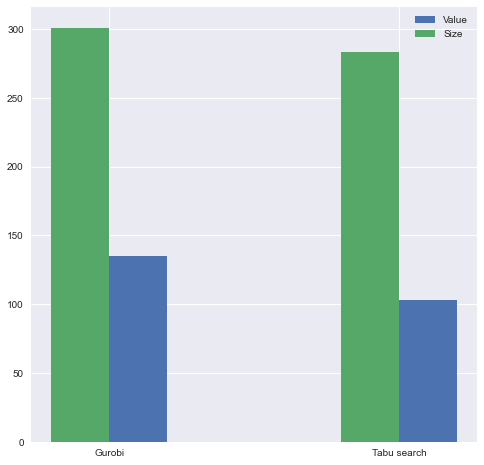

In [146]:
labels = np.array(['Gurobi','Tabu search'])
x = np.arange(len(labels))
res_value = [sum_value,value_max]
res_size = [sum_size,size_max]
width=0.2
plt.figure(figsize=(8,8))
plt.style.use('seaborn')
plt.bar(x+width/2,res_value,width,label="Value")
plt.bar(x-width/2,res_size,width,label="Size")
plt.xticks(x,labels=labels)
plt.legend()
plt.grid(which='both', alpha=1)
plt.show()